In [1]:
# Importing ML and python Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# Importing Deep Learning Libraries 
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=0)

In [5]:
# define transformations for data augmentation

transform_original = transforms.Compose([
    transforms.ToTensor(),  # convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize the images
])

transform1 = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.RandomRotation(degrees=(-20, 20)),  # Example transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform3 = transforms.Compose([
    transforms.RandomRotation(degrees=(-80, 80)),  # Example transformation
    transforms.RandomAffine((-65,65)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
batch_size = 32
shuffle = True

In [7]:
train_dataset_org = datasets.ImageFolder("./train", transform=transform_original)
train_dataset_1 = datasets.ImageFolder("./train", transform=transform1)
train_dataset_2 = datasets.ImageFolder("./train", transform=transform2)
train_dataset_3 = datasets.ImageFolder("./train", transform=transform3)

In [8]:
trainset = ConcatDataset([train_dataset_org,train_dataset_1, train_dataset_2, train_dataset_3])

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)

In [10]:
testset = (datasets.ImageFolder("./test", transform=transform_original))
testloader = DataLoader(testset, batch_size=batch_size, shuffle=shuffle)

In [11]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

In [12]:
def print_label_count(dataloader, classes):
    """
    Visualizes label distribution in a dataloader as a bar plot.
    """
    all_labels = []
    for _, labels in dataloader:
        all_labels.extend(labels.numpy())  # Accumulate labels from batches

    unique_labels, counts = np.unique(all_labels, return_counts=True)

    plt.bar(unique_labels, counts)

    # Add labels and title
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.xticks(unique_labels, [classes[i] for i in unique_labels])  # Label with class names
    plt.title('Label Distribution in Dataloader')

    # Show plot
    plt.show()

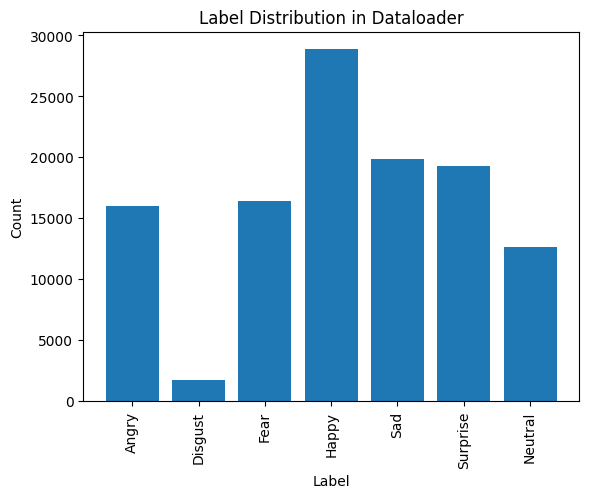

In [13]:
print_label_count(trainloader,classes)

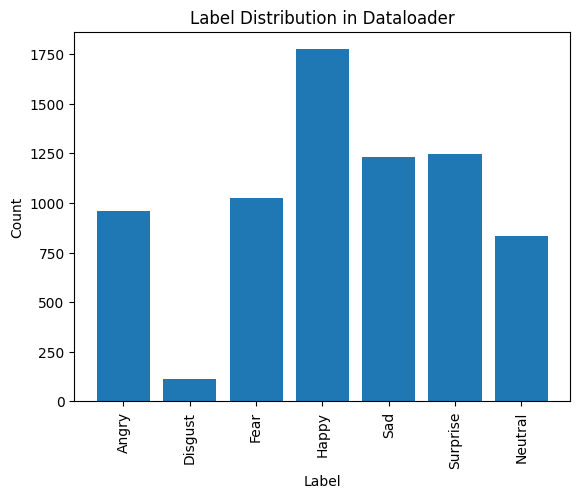

In [14]:
print_label_count(testloader,classes)

In [15]:
def count_images_and_classes(dataloader, classes):
    """
    Counts the number of images and occurrences of each class in a dataloader.
    """
    total_count = 0
    class_counts = {cls: 0 for cls in classes}

    for _, labels in dataloader:
        total_count += labels.size(0)  # Add batch size
        for label in labels:
            class_counts[classes[label]] += 1

    print(f"Total number of images: {total_count}")
    print("Class counts:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

In [16]:
count_images_and_classes(trainloader, classes)


Total number of images: 114836
Class counts:
Angry: 15980
Disgust: 1744
Fear: 16388
Happy: 28860
Sad: 19860
Surprise: 19320
Neutral: 12684


In [17]:
count_images_and_classes(testloader, classes)


Total number of images: 7178
Class counts:
Angry: 958
Disgust: 111
Fear: 1024
Happy: 1774
Sad: 1233
Surprise: 1247
Neutral: 831


In [18]:
epoch_size = 70

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels: 1 (grayscale), Output channels: 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)


        # Define pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 1 * 1, 128)  # Assuming input image size is 48x48 after 4 pooling layers
        self.fc2 = nn.Linear(128, 7)  # 7 output emotions

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))


        # Flatten feature maps
        x = torch.flatten(x, 1) # flatten all dimensions except batch      

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
model = FERModel()
model.to(device)

FERModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

In [21]:
import torch.optim as optim
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
# lists to store loss and accuracy for each epoch

epoch_losses = []
epoch_accuracies = []

for epoch in range(epoch_size):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) #for GPU

        # zero the parameter gradients for no gradient accumulation
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate running loss
        running_loss += loss.item()
        # Calculate running accuracy (assuming you have a function `get_accuracy`)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store epoch loss and accuracy
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{epoch_size}] loss: {epoch_loss:.3f}, accuracy: {epoch_accuracy:.3f}%')


print('Finished Training')

Epoch [1/70] loss: 1.816, accuracy: 25.206%
Epoch [2/70] loss: 1.770, accuracy: 26.479%
Epoch [3/70] loss: 1.730, accuracy: 29.149%
Epoch [4/70] loss: 1.661, accuracy: 33.321%
Epoch [5/70] loss: 1.567, accuracy: 38.504%
Epoch [6/70] loss: 1.483, accuracy: 42.304%
Epoch [7/70] loss: 1.405, accuracy: 45.772%
Epoch [8/70] loss: 1.335, accuracy: 48.861%
Epoch [9/70] loss: 1.277, accuracy: 51.194%
Epoch [10/70] loss: 1.223, accuracy: 53.288%
Epoch [11/70] loss: 1.172, accuracy: 55.492%
Epoch [12/70] loss: 1.129, accuracy: 57.337%
Epoch [13/70] loss: 1.083, accuracy: 59.110%
Epoch [14/70] loss: 1.043, accuracy: 60.974%
Epoch [15/70] loss: 1.003, accuracy: 62.594%
Epoch [16/70] loss: 0.967, accuracy: 64.145%
Epoch [17/70] loss: 0.929, accuracy: 65.570%
Epoch [18/70] loss: 0.896, accuracy: 66.978%
Epoch [19/70] loss: 0.859, accuracy: 68.402%
Epoch [20/70] loss: 0.829, accuracy: 69.648%
Epoch [21/70] loss: 0.800, accuracy: 70.827%
Epoch [22/70] loss: 0.774, accuracy: 71.900%
Epoch [23/70] loss:

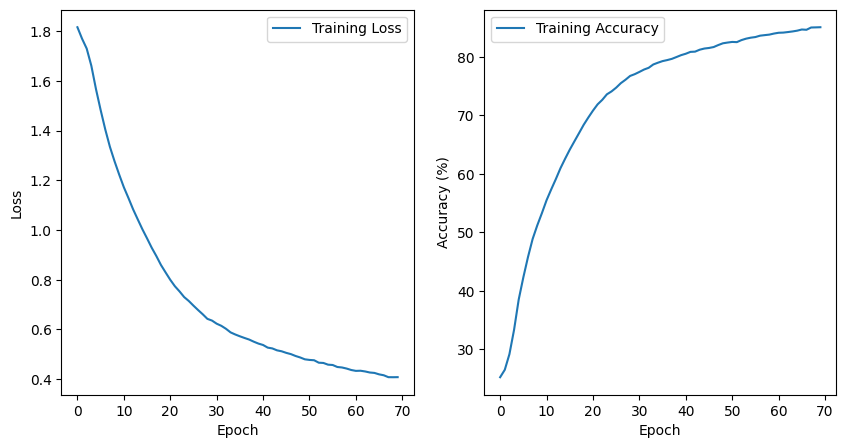

Finished Training


In [23]:
# Plotting after training
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_accuracies, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

print('Finished Training')

In [24]:
PATH = './cnnfer_net.pth'
torch.save(model.state_dict(), PATH)

In [25]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device) #for GPU
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %
